# simulation experiment
The composition schema was developed for integrative simulations, but can also be used for workflows such as simulation experiments. This experimental notebook demonstrates simulation experiments as composites, going from the declarative JSON format to executable python script.  

Example scripts were provided here: https://docs.google.com/document/d/1jZkaNhM_cOqMWtd4sJZ9b0VGXPTLsDKsRNI5Yvu4nOA/edit

### imports

In [1]:
from sed2 import sed_process_registry, annotate, ports, register
from sed2.core import (
    serialize_instance, generate_script, register_functions, generate_composite_process, get_process_schema)
from bigraph_viz import plot_bigraph, plot_flow, pf
import numpy as np

### print the sed process registry
These are the sed processes required to generate all of the examples. The processes used in this notebook are imported from a local library `sed2` and are added to the global namespace for easy calls. Different instances may use remote processes accessed as a service, or local Docker containers, or combinations of these.

In [2]:
# add sed processes to global namespace
sed_process_registry.activate_all(globals())
print(pf(sed_process_registry.registry))

{ 'concentration_control_coefficient': { 'address': <function concentration_control_coefficient at 0x16b4ce670>,
                                         'annotation': 'sed:is_steady_state',
                                         'ports': { 'inputs': { 'model': 'Model',
                                                                'parameter': 'string',
                                                                'variable': 'string'},
                                                    'outputs': { 'coefficient': 'float'}}},
  'data_description': { 'address': <function data_description at 0x16b4ce3a0>,
                        'annotation': 'sed:data_description',
                        'ports': { 'inputs': { 'data_file': 'str',
                                               'file_format': 'str'},
                                   'outputs': {'data': 'pd.DataFrame'}}},
  'is_steady_state': { 'address': <function is_steady_state at 0x16b4ce5e0>,
                       'annotati

### example 1
Run a simulation from time start to time end with a given number of points/steps.  The run will return a 2D array of results.

This is the script we aim to reproduce with SED-2:
```
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
sim1 = uniform_time_course(model_instance, 0, 10, 50, selection_list=['time', 'S', 'Z'])
curves = {
    'Susceptible': {'x': 'time', 'y': 'S'},
    'Zombie': {'x': 'time', 'y': 'Z'}
}
plot2d(results=sim1, curves=curves, name='Figure3')
```

#### SED-2 document

This declarative document describes the simulation experiment, with values and processes all declared in a simple format which can be serialized to JSON and shared.

In [3]:
# SED document serialized
instance1 = {
    'time_start': 0,
    'time_end': 10,
    'num_points': 50,
    'selection_list': ['time', 'S', 'Z'],
    'model_path': '"susceptible_zombie.xml"',
    'curves': {
        'Susceptible': {'x': 'time', 'y': 'S'},
        'Zombie': {'x': 'time', 'y': 'Z'}
    },
    'figure1name': '"Figure1"',
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
    },
    'plot2d': {
        '_type': 'sed:plot2d',
        'wires': {
            'results': 'results',
            'curves': 'curves',
            'name': 'figure1name',
        },
        '_depends_on': ['uniform_time_course'],
    },
    'uniform_time_course': {
        '_type': 'sed:uniform_time_course',
        'wires': {
            'model': 'model_instance',
            'time_start': 'time_start',
            'time_end': 'time_end',
            'num_points': 'num_points',
            'selection_list': 'selection_list',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path'],
    },
}

# fill(instance)  # autocomplete
# validate_schema(instance) # TODO -- demonstrate validation

# Serialize to JSON
json_str1 = serialize_instance(instance1)
print(json_str1)

{"time_start": 0, "time_end": 10, "num_points": 50, "selection_list": ["time", "S", "Z"], "model_path": "\"susceptible_zombie.xml\"", "curves": {"Susceptible": {"x": "time", "y": "S"}, "Zombie": {"x": "time", "y": "Z"}}, "figure1name": "\"Figure1\"", "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}}, "plot2d": {"_type": "sed:plot2d", "wires": {"results": "results", "curves": "curves", "name": "figure1name"}, "_depends_on": ["uniform_time_course"]}, "uniform_time_course": {"_type": "sed:uniform_time_course", "wires": {"model": "model_instance", "time_start": "time_start", "time_end": "time_end", "num_points": "num_points", "selection_list": "selection_list", "results": "results"}, "_depends_on": ["sbml_model_from_path"]}}


#### from JSON string to Python script

In [4]:
uniform_time_course.ports

{'inputs': {'model': 'Model',
  'time_start': 'float',
  'time_end': 'float',
  'num_points': 'int',
  'selection_list': 'List[str]'},
 'outputs': {'results': 'dict'}}

In [5]:
# Generate the script
script1 = generate_script(json_str1, sed_process_registry)
print(script1)

figure1name = "Figure1"
curves = {'Susceptible': {'x': 'time', 'y': 'S'}, 'Zombie': {'x': 'time', 'y': 'Z'}}
model_path = "susceptible_zombie.xml"
selection_list = ['time', 'S', 'Z']
num_points = 50
time_end = 10
time_start = 0
model_instance = sbml_model_from_path(path_to_sbml=model_path)
results = uniform_time_course(model=model_instance, time_start=time_start, time_end=time_end, num_points=num_points, selection_list=selection_list)
plot2d(results=results, curves=curves, name=figure1name)


#### Execute the script
You get the same results as above

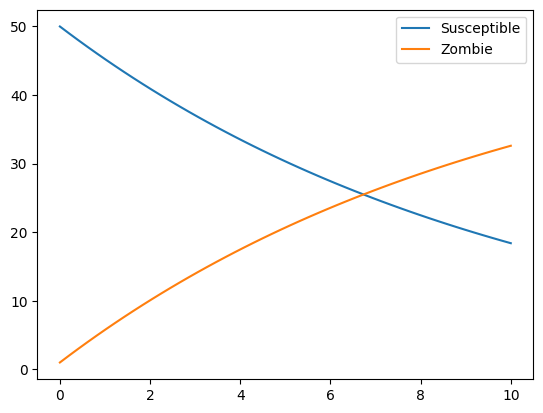

In [6]:
# Execute the script
exec(script1)

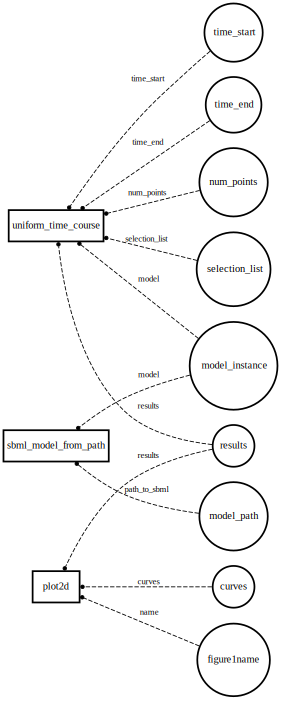

In [7]:
# Plot function map
remove_nodes = [('curves', 'Susceptible'),('curves', 'Zombie'),]
plot_bigraph(instance1, remove_nodes=remove_nodes, rankdir='RL')

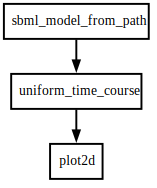

In [8]:
# Plot the flow diagram
plot_flow(instance1)

### example 2
Run a single steady-state simulation, The run returns a 1D array containing the steady state values.

The script we aim to generate:
```
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
ss1 = steady_state_values(model_instance, selection_list=['S', 'Z'])
report(ss1, title='Steady States')
```

#### SED-2 document

In [9]:
# SED document serialized
instance2 = {
    'model_path': '"susceptible_zombie.xml"',
    'UTC': '"UTC"',
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
    },
    'steady_state_values': {
        '_type': 'sed:steady_state_values',
        'wires': {
            'model': 'model_instance',
            'time_start': 'time_start',
            'time_end': 'time_end',
            'num_points': 'num_points',
            'selection_list': 'selection_list',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'report': {
        '_type': 'sed:report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['steady_state_values']
    }
}

# Serialize to JSON
json_str2 = serialize_instance(instance2)
print(json_str2)

{"model_path": "\"susceptible_zombie.xml\"", "UTC": "\"UTC\"", "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}}, "steady_state_values": {"_type": "sed:steady_state_values", "wires": {"model": "model_instance", "time_start": "time_start", "time_end": "time_end", "num_points": "num_points", "selection_list": "selection_list", "results": "results"}, "_depends_on": ["sbml_model_from_path"]}, "report": {"_type": "sed:report", "wires": {"results": "results", "title": "UTC"}, "_depends_on": ["steady_state_values"]}}


#### from JSON string to Python script

In [10]:
# Generate the script
script2 = generate_script(json_str2, sed_process_registry)
print(script2)

UTC = "UTC"
model_path = "susceptible_zombie.xml"
model_instance = sbml_model_from_path(path_to_sbml=model_path)
results = steady_state_values(model=model_instance, selection_list=selection_list)
report(results=results, title=UTC)


In [11]:
# Execute the script
exec(script2)

UTC
S: 1.0587911840678754e-22
Z: 51.0


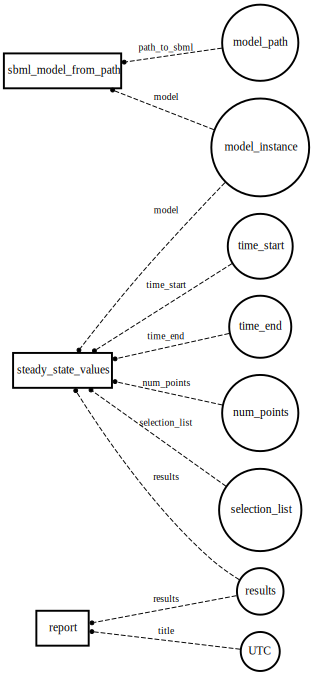

In [12]:
# Plot function map
plot_bigraph(instance2, rankdir='RL')

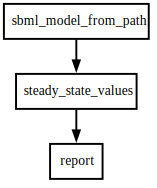

In [13]:
# Plot flow diagram
plot_flow(instance2)

### example 3
Set parameters and/or initial conditions and run time course or steady state evaluation.

```
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
set_model(model_instance, 'Z', 0.0)
ss1 = steady_state_values(model_instance, selection_list=['S', 'Z'])
report(ss1, title='Steady States')
```

#### SED-2 document

In [14]:
# SED document serialized
instance3 = {
    'model_path': '"susceptible_zombie.xml"',
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
    },
    'element_id': '"Z"',
    'element_value': 0.0,
    'model_set_value': {
        '_type': 'sed:set_model',
        'wires': {
            'model_instance': 'model_instance',
            'element_id': 'element_id',
            'value': 'element_value'
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'steady_state_values': {
        '_type': 'sed:steady_state_values',
        'wires': {
            'model': 'model_instance',
            'time_start': 'time_start',
            'time_end': 'time_end',
            'num_points': 'num_points',
            'selection_list': 'selection_list',
            'results': 'results',
        },
        '_depends_on': ['model_set_value']
    },
    'report': {
        '_type': 'sed:report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['steady_state_values']
    }
}

# Serialize to JSON
json_str3 = serialize_instance(instance3)
print(json_str3)

{"model_path": "\"susceptible_zombie.xml\"", "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}}, "element_id": "\"Z\"", "element_value": 0.0, "model_set_value": {"_type": "sed:set_model", "wires": {"model_instance": "model_instance", "element_id": "element_id", "value": "element_value"}, "_depends_on": ["sbml_model_from_path"]}, "steady_state_values": {"_type": "sed:steady_state_values", "wires": {"model": "model_instance", "time_start": "time_start", "time_end": "time_end", "num_points": "num_points", "selection_list": "selection_list", "results": "results"}, "_depends_on": ["model_set_value"]}, "report": {"_type": "sed:report", "wires": {"results": "results", "title": "UTC"}, "_depends_on": ["steady_state_values"]}}


#### from JSON string to Python script

In [15]:
# Generate the script
script3 = generate_script(json_str3, sed_process_registry)
print(script3)

element_value = 0.0
element_id = "Z"
model_path = "susceptible_zombie.xml"
model_instance = sbml_model_from_path(path_to_sbml=model_path)
model_set_value(model_instance=model_instance, element_id=element_id, value=element_value)
results = steady_state_values(model=model_instance, selection_list=selection_list)
report(results=results, title=UTC)


In [16]:
# Execute the script
exec(script3)

UTC
S: 1.0587911840678754e-22
Z: 51.0


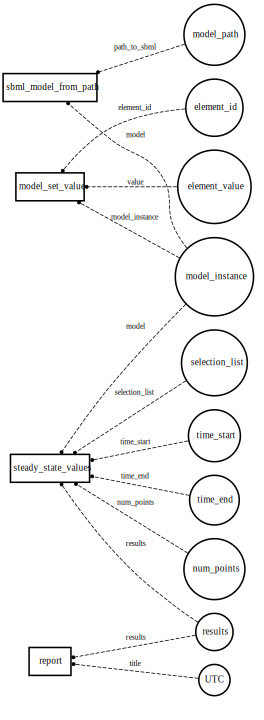

In [17]:
# Plot function map
plot_bigraph(instance3, rankdir='RL')

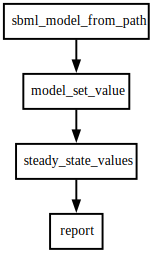

In [18]:
# Plot flow diagram
plot_flow(instance3)

### example 4
Repeat simulations any number of times and with any degree of nesting.  Any changes may be applied to parameters, initial conditions etc within the repeated simulations.  The results of the simulation will be collected into arrays.
```
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
config = {
    'Z': list(range(1, 11))
}
results = repeated_simulation(model_instance, config)
report(results, title='Different starting Z values')
```

#### SED-2 document

In [19]:
# SED document serialized
instance4 = {
    'model_path': '"susceptible_zombie.xml"',
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
    },
    'repeated_sim_config':{'Z': list(range(1, 11))},
    'repeated_simulation': {
        '_type': 'sed:repeated_simulation',
        'wires': {
            'model_instance': 'model_instance',
            'config': 'repeated_sim_config',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'report': {
        '_type': 'sed:report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['repeated_simulation']
    }
}

# Serialize to JSON
json_str4 = serialize_instance(instance4)
print(json_str4)

{"model_path": "\"susceptible_zombie.xml\"", "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}}, "repeated_sim_config": {"Z": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, "repeated_simulation": {"_type": "sed:repeated_simulation", "wires": {"model_instance": "model_instance", "config": "repeated_sim_config", "results": "results"}, "_depends_on": ["sbml_model_from_path"]}, "report": {"_type": "sed:report", "wires": {"results": "results", "title": "UTC"}, "_depends_on": ["repeated_simulation"]}}


#### from JSON string to Python script

In [20]:
# Generate the script
script4 = generate_script(json_str4, sed_process_registry)
print(script4)

repeated_sim_config = {'Z': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
model_path = "susceptible_zombie.xml"
model_instance = sbml_model_from_path(path_to_sbml=model_path)
results = repeated_simulation(model_instance=model_instance, config=repeated_sim_config)
report(results=results, title=UTC)


In [21]:
# Execute the script
exec(script4)

UTC
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94003035 30.32651341 23.61828935 18.39390318]
Z: [ 1.         12.05996965 20.67348659 27.38171065 32.60609682]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004271 30.3265222  23.61829995 18.39387556]
Z: [ 2.         13.05995729 21.6734778  28.38170005 33.60612444]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004572 30.32652512 23.6183302  18.39399716]
Z: [ 3.         14.05995428 22.67347488 29.3816698  34.60600284]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94005934 30.32656148 23.61832184 18.39393547]
Z: [ 4.         15.05994066 23.67343852 30.38167816 35.60606453]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94006923 30.32664465 23.61839919 18.39396   ]
Z: [ 5.         16.05993077 24.67335535 31.38160081 36.60604   ]
time: [ 0.   2.5  5.   7.5 10. ]
S: [50.         38.94004474 30.32656757 23.61833607 18.39394121]
Z: [ 6.         17.05995526 25.67343243 32.38166393 37.60605879]
time: [ 0.   2.5  

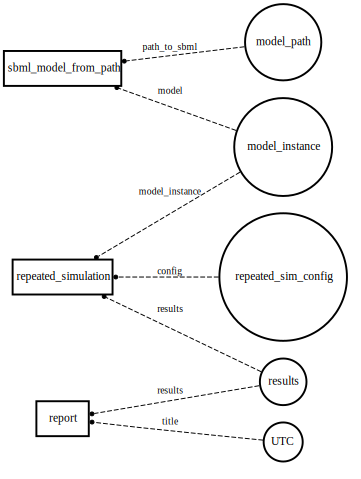

In [22]:
# Plot function map
remove_nodes = [('repeated_sim_config', 'Z')]
plot_bigraph(instance4, remove_nodes=remove_nodes, rankdir='RL')

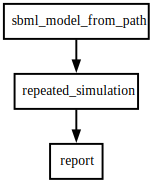

In [23]:
# Plot flow diagram
plot_flow(instance4)

### example 5
Carry out an n-D parameter scan and return the results in an array.
```
model_instance = Model('urn:sedml:language:sbml', 'susceptible_zombie.xml')
SZ_data = data_description('susceptible_zombie.csv', 'CSV')
config = {
    'S': np.arange(0.0, 0.010, step=0.002),
    'Z': np.arange(0.0, 0.010, step=0.002)
}
results = n_dimensional_scan(
    input_dict=config, 
    model=model_instance,
    data_description=SZ_data,
    time_start=0, 
    time_end=10, 
    num_points=5
)
report(results, title='Parameter scan')
```

#### SED-2 document

In [24]:
# SED document serialized
instance5 = {
    'model_path': '"susceptible_zombie.xml"',
    'data_description_path': '"susceptible_zombie.csv"',
    'data_format': '"CSV"',
    'UTC': '"UTC"',
    'time_start': 0,
    'time_end': 10,
    'num_points': 5,
    'sbml_model_from_path': {
        '_type': 'sed:sbml_model_from_path',
        'wires': {
            'path_to_sbml': 'model_path',
            'model': 'model_instance'
        },
    },
    'data_description': {
        '_type': 'sed:data_description',
        'wires': {
            'data_file': 'data_description_path',
            'file_format': 'data_format',
            'data': 'SZ_data',  # the output
        },
    },
    'n_dimensional_scan_config': {
        'S': np.arange(0.0, 0.010, step=0.002),
        'Z': np.arange(0.0, 0.010, step=0.002)
    },
    'n_dimensional_scan': {
        '_type': 'sed:n_dimensional_scan',
        'wires': {'input_dict': 'dict',
            'input_dict': 'n_dimensional_scan_config',
            'model': 'model_instance',
            'data_description': 'SZ_data',
            'time_start': 'time_start',
            'time_end': 'time_end',
            'num_points': 'num_points',
            'results': 'results',
        },
        '_depends_on': ['sbml_model_from_path']
    },
    'report': {
        '_type': 'sed:report',
        'wires': {
            'results': 'results',
            'title': 'UTC'  # this should be optional
        },
        '_depends_on': ['n_dimensional_scan']
    }
}

# Serialize to JSON
json_str5 = serialize_instance(instance5)
print(json_str5)

{"model_path": "\"susceptible_zombie.xml\"", "data_description_path": "\"susceptible_zombie.csv\"", "data_format": "\"CSV\"", "UTC": "\"UTC\"", "time_start": 0, "time_end": 10, "num_points": 5, "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}}, "data_description": {"_type": "sed:data_description", "wires": {"data_file": "data_description_path", "file_format": "data_format", "data": "SZ_data"}}, "n_dimensional_scan_config": {"S": [0.0, 0.002, 0.004, 0.006, 0.008], "Z": [0.0, 0.002, 0.004, 0.006, 0.008]}, "n_dimensional_scan": {"_type": "sed:n_dimensional_scan", "wires": {"input_dict": "n_dimensional_scan_config", "model": "model_instance", "data_description": "SZ_data", "time_start": "time_start", "time_end": "time_end", "num_points": "num_points", "results": "results"}, "_depends_on": ["sbml_model_from_path"]}, "report": {"_type": "sed:report", "wires": {"results": "results", "title": "UTC"}, "_depends_on":

#### from JSON string to Python script

In [25]:
# Generate the script
script5 = generate_script(json_str5, sed_process_registry)
print(script5)

n_dimensional_scan_config = {'S': [0.0, 0.002, 0.004, 0.006, 0.008], 'Z': [0.0, 0.002, 0.004, 0.006, 0.008]}
num_points = 5
time_end = 10
time_start = 0
UTC = "UTC"
data_format = "CSV"
data_description_path = "susceptible_zombie.csv"
model_path = "susceptible_zombie.xml"
model_instance = sbml_model_from_path(path_to_sbml=model_path)
SZ_data = data_description(data_file=data_description_path, file_format=data_format)
results = n_dimensional_scan(input_dict=n_dimensional_scan_config, model=model_instance, data_description=SZ_data, time_start=time_start, time_end=time_end, num_points=num_points)
report(results=results, title=UTC)


In [26]:
# Execute the script
exec(script5)

UTC
(0.0, 0.0): 0.0
(0.0, 0.002): 0.0
(0.0, 0.004): 0.0
(0.0, 0.006): 0.0
(0.0, 0.008): 0.0
(0.002, 0.0): 0.0
(0.002, 0.002): 0.0
(0.002, 0.004): 0.0
(0.002, 0.006): 0.0
(0.002, 0.008): 0.0
(0.004, 0.0): 0.0
(0.004, 0.002): 0.0
(0.004, 0.004): 0.0
(0.004, 0.006): 0.0
(0.004, 0.008): 0.0
(0.006, 0.0): 0.0
(0.006, 0.002): 0.0
(0.006, 0.004): 0.0
(0.006, 0.006): 0.0
(0.006, 0.008): 0.0
(0.008, 0.0): 0.0
(0.008, 0.002): 0.0
(0.008, 0.004): 0.0
(0.008, 0.006): 0.0
(0.008, 0.008): 0.0


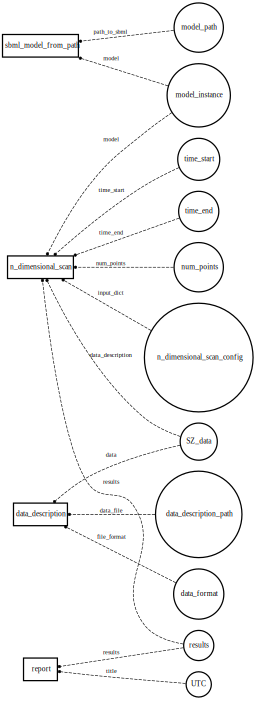

In [27]:
# Plot function map
remove_nodes = [('n_dimensional_scan_config', 'S'), ('n_dimensional_scan_config', 'Z')]
plot_bigraph(instance5, remove_nodes=remove_nodes, rankdir='RL')

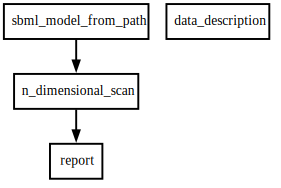

In [28]:
# Plot flow diagram
plot_flow(instance5)

## Composite Processes

Make a composite process from the composition of example 5, which only exposes a few outer ports.

### declare outer ports, added to the JSON instance from example 5

In [29]:
# add ports to the previous toy instance
instance5x = {
    **instance5,
    '_ports': {
        'inputs': {
            'n_dimensional_scan_config': 'dict',
        },
    },
}

# Serialize to JSON
json_str5x = serialize_instance(instance5x)
print(json_str5x)

{"model_path": "\"susceptible_zombie.xml\"", "data_description_path": "\"susceptible_zombie.csv\"", "data_format": "\"CSV\"", "UTC": "\"UTC\"", "time_start": 0, "time_end": 10, "num_points": 5, "sbml_model_from_path": {"_type": "sed:sbml_model_from_path", "wires": {"path_to_sbml": "model_path", "model": "model_instance"}}, "data_description": {"_type": "sed:data_description", "wires": {"data_file": "data_description_path", "file_format": "data_format", "data": "SZ_data"}}, "n_dimensional_scan_config": {"S": [0.0, 0.002, 0.004, 0.006, 0.008], "Z": [0.0, 0.002, 0.004, 0.006, 0.008]}, "n_dimensional_scan": {"_type": "sed:n_dimensional_scan", "wires": {"input_dict": "n_dimensional_scan_config", "model": "model_instance", "data_description": "SZ_data", "time_start": "time_start", "time_end": "time_end", "num_points": "num_points", "results": "results"}, "_depends_on": ["sbml_model_from_path"]}, "report": {"_type": "sed:report", "wires": {"results": "results", "title": "UTC"}, "_depends_on":

### Generate the Composite Process

In [30]:
# Generate the composite
composite_process = generate_composite_process(json_str5x, sed_process_registry)

@ports({'inputs': {'n_dimensional_scan_config': 'dict'}})
def composite_process(n_dimensional_scan_config: dict = {'S': [0.0, 0.002, 0.004, 0.006, 0.008], 'Z': [0.0, 0.002, 0.004, 0.006, 0.008]}):
    num_points = 5
    time_end = 10
    time_start = 0
    UTC = "UTC"
    data_format = "CSV"
    data_description_path = "susceptible_zombie.csv"
    model_path = "susceptible_zombie.xml"
    model_instance = sbml_model_from_path(path_to_sbml=model_path)
    SZ_data = data_description(data_file=data_description_path, file_format=data_format)
    results = n_dimensional_scan(input_dict=n_dimensional_scan_config, model=model_instance, data_description=SZ_data, time_start=time_start, time_end=time_end, num_points=num_points)
    report(results=results, title=UTC)


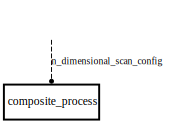

In [31]:
plot_bigraph(get_process_schema(composite_process))

In [32]:
# run the process with default settings, generates the same results as above
composite_process()

UTC
(0.0, 0.0): 0.0
(0.0, 0.002): 0.0
(0.0, 0.004): 0.0
(0.0, 0.006): 0.0
(0.0, 0.008): 0.0
(0.002, 0.0): 0.0
(0.002, 0.002): 0.0
(0.002, 0.004): 0.0
(0.002, 0.006): 0.0
(0.002, 0.008): 0.0
(0.004, 0.0): 0.0
(0.004, 0.002): 0.0
(0.004, 0.004): 0.0
(0.004, 0.006): 0.0
(0.004, 0.008): 0.0
(0.006, 0.0): 0.0
(0.006, 0.002): 0.0
(0.006, 0.004): 0.0
(0.006, 0.006): 0.0
(0.006, 0.008): 0.0
(0.008, 0.0): 0.0
(0.008, 0.002): 0.0
(0.008, 0.004): 0.0
(0.008, 0.006): 0.0
(0.008, 0.008): 0.0


In [33]:
# pass in new settings through the exposed port
n_dimensional_scan_config = {
    'S': np.arange(0.0, 0.1, step=0.005),
    'Z': np.arange(0.0, 0.1, step=0.05)
}
result = composite_process(n_dimensional_scan_config=n_dimensional_scan_config)

UTC
(0.0, 0.0): 0.0
(0.0, 0.05): 0.0
(0.005, 0.0): 0.0
(0.005, 0.05): 0.0
(0.01, 0.0): 0.0
(0.01, 0.05): 0.0
(0.015, 0.0): 0.0
(0.015, 0.05): 0.0
(0.02, 0.0): 0.0
(0.02, 0.05): 0.0
(0.025, 0.0): 0.0
(0.025, 0.05): 0.0
(0.03, 0.0): 0.0
(0.03, 0.05): 0.0
(0.035, 0.0): 0.0
(0.035, 0.05): 0.0
(0.04, 0.0): 0.0
(0.04, 0.05): 0.0
(0.045, 0.0): 0.0
(0.045, 0.05): 0.0
(0.05, 0.0): 0.0
(0.05, 0.05): 0.0
(0.055, 0.0): 0.0
(0.055, 0.05): 0.0
(0.06, 0.0): 0.0
(0.06, 0.05): 0.0
(0.065, 0.0): 0.0
(0.065, 0.05): 0.0
(0.07, 0.0): 0.0
(0.07, 0.05): 0.0
(0.075, 0.0): 0.0
(0.075, 0.05): 0.0
(0.08, 0.0): 0.0
(0.08, 0.05): 0.0
(0.085, 0.0): 0.0
(0.085, 0.05): 0.0
(0.09, 0.0): 0.0
(0.09, 0.05): 0.0
(0.095, 0.0): 0.0
(0.095, 0.05): 0.0
